<a href="https://colab.research.google.com/github/BakhtawarRehman/Facial-Emotion-Recognition/blob/master/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [0]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils

import os
import cv2

%matplotlib inline

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
path = '/content/drive/My Drive/fer2013.csv'
data = pd.read_csv(path)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


This dataset is about finding the right emotion. There are seven universal facial emotions (according to many studies; some modern studies might not agree): happy, sad, angry, afraid, surprise,disgust, and neutral

In [105]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [106]:
# Check if there are any null entries
train = data[["emotion", "pixels"]][data["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [107]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [108]:
train['pixels'][0]

array([ 70.,  80.,  82., ..., 106., 109.,  82.])

In [109]:
#For validation
public_test_df = data[["emotion", "pixels"]][data["Usage"]=="PublicTest"]

public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_val = np.vstack(public_test_df["pixels"].values)
y_val = np.array(public_test_df["emotion"])

x_val.shape, y_val.shape

((3589, 2304), (3589,))

In [110]:
#Data in usable format
x_train = x_train.reshape(-1, 48, 48, 1)
x_val = x_val.reshape(-1, 48, 48, 1)
x_train.shape, x_val.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [111]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_train.shape, y_val.shape

((28709, 7), (3589, 7))

In [0]:

class_names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

<function matplotlib.pyplot.show>

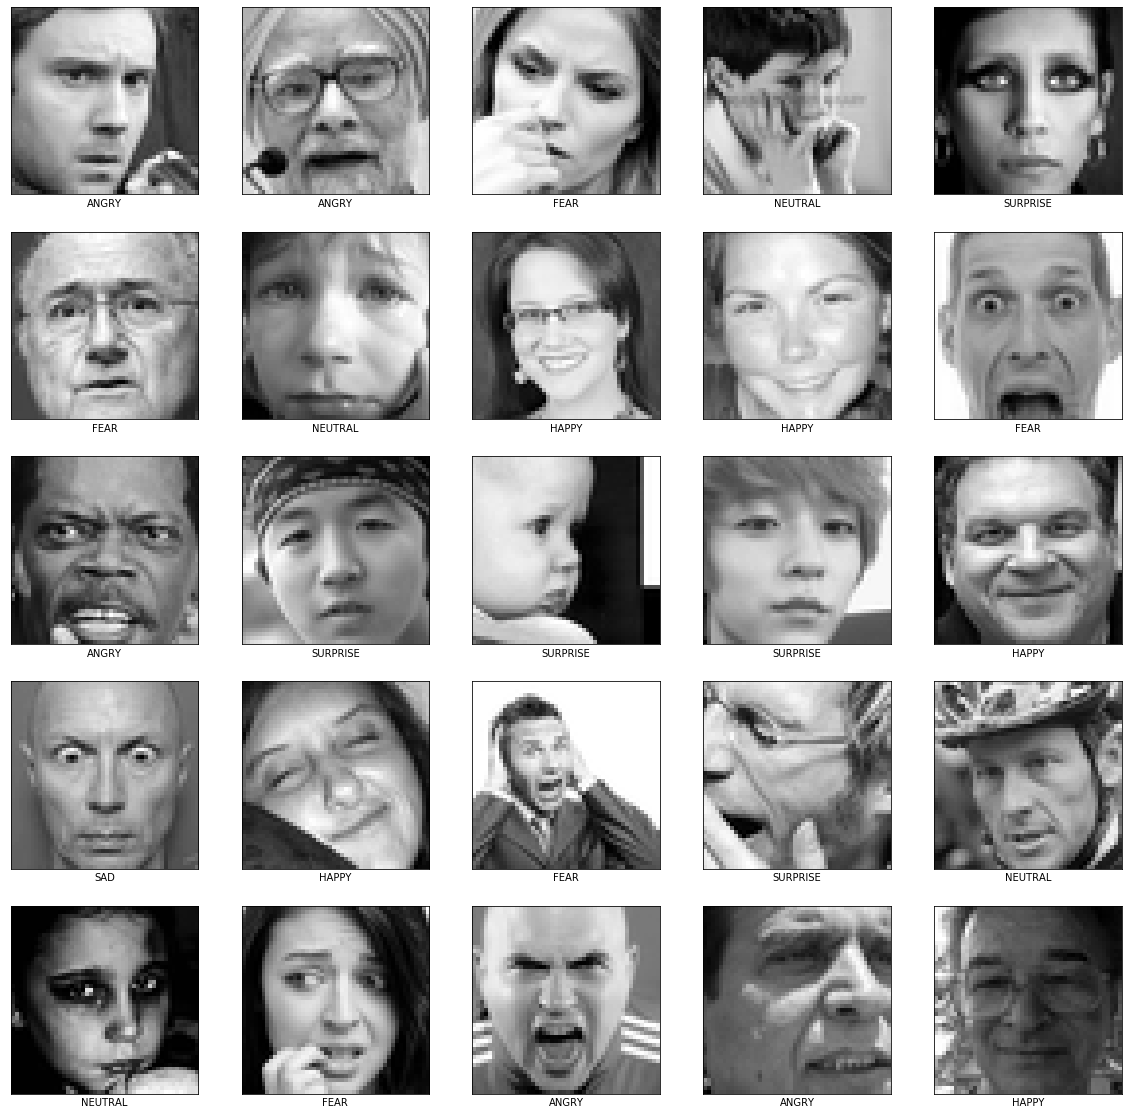

In [113]:
#Here we are going to display the data
# TO See how it looks like
# Earlier we re-format the data and each image dimension = (48,48,1)
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # matplot lib's plt need this to be squeezed into (48,48); otherwise it will show an error.
    plt.imshow(np.squeeze(x_train[i]), cmap='gray')
    plt.xlabel(class_names[np.argmax(y_train[i])])
plt.show

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 60

This below network design is inspired from a refernce with a little bit of tweaking.


In [115]:
# For training without AUGmentation: 0.5 for dropout layer was used. Less data and overfitting was the reason.

model = keras.Sequential ([
    keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(2*2*2*num_features, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(2*2*num_features, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2*num_features, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 42, 42, 128)       73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 42, 42, 128)       512       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 128)      

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# Callbacks
#earlyStopping = EarlyStopping(monitor='val_loss', patience=5)
#mcp_save = ModelCheckpoint('/content/drive/My Drive/dataFiles', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=7, min_lr=0.0001)

In [118]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[ reduce_lr_loss], validation_data=(x_val, y_val), shuffle=True)

Train on 28709 samples, validate on 3589 samples
Epoch 1/60
28709/28709 [==============================] - 20s 714us/sample - loss: 1.9485 - accuracy: 0.2381 - val_loss: 1.6896 - val_accuracy: 0.3207
Epoch 2/60
28709/28709 [==============================] - 19s 654us/sample - loss: 1.6700 - accuracy: 0.3353 - val_loss: 1.7212 - val_accuracy: 0.3135
Epoch 3/60
28709/28709 [==============================] - 19s 653us/sample - loss: 1.5157 - accuracy: 0.4067 - val_loss: 1.5622 - val_accuracy: 0.3840
Epoch 4/60
28709/28709 [==============================] - 19s 654us/sample - loss: 1.3947 - accuracy: 0.4661 - val_loss: 1.3307 - val_accuracy: 0.4904
Epoch 5/60
28709/28709 [==============================] - 19s 654us/sample - loss: 1.3159 - accuracy: 0.5017 - val_loss: 1.4697 - val_accuracy: 0.4294
Epoch 6/60
28709/28709 [==============================] - 19s 653us/sample - loss: 1.2634 - accuracy: 0.5226 - val_loss: 1.2265 - val_accuracy: 0.5300
Epoch 7/60
28709/28709 [=====================

3589/3589 - 1s - loss: 2.9715 - accuracy: 0.6467


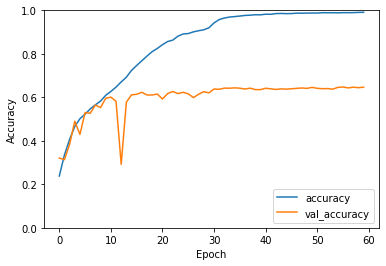

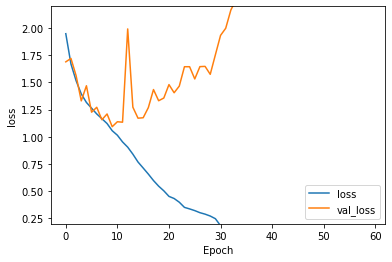

<Figure size 432x288 with 0 Axes>

In [119]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.figure()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.2, 2.2])
plt.legend(loc='lower right')
plt.figure()

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

**What can we learn from this graph?** 
> 
After 15th epoch, accuracy is almost constant and lass has gone way too high.

I should have employed earlystopping here but in previous runs of the model it didnot help alot. So, i will try it with image augmentation below.

In [0]:
predictions = model.predict(x_val)

<function matplotlib.pyplot.show>

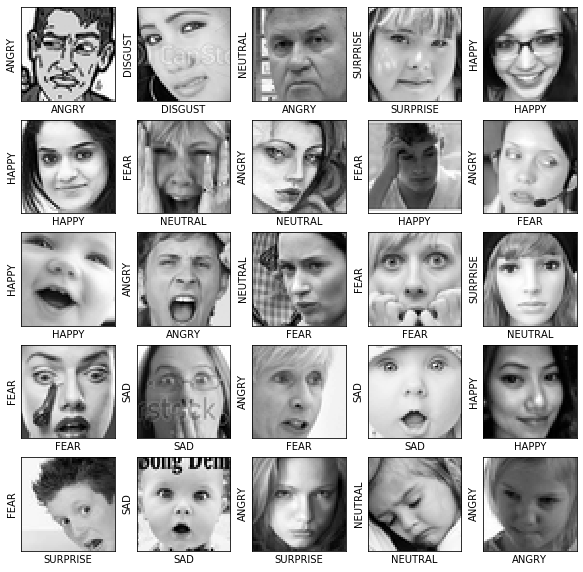

In [121]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_val[i]), cmap='gray')
    plt.xlabel(class_names[np.argmax(predictions[i])])
    plt.ylabel(class_names[np.argmax(y_val[i])])
plt.show

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   #vertical_flip = True,
                                   fill_mode = 'mirror')



###############
test_datagen = ImageDataGenerator(rescale = 1./255.,)

In [0]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [0]:

# Callbacks
earlyStopping = EarlyStopping(monitor='val_loss', patience=5)
mcp_save = ModelCheckpoint('/content/drive/My Drive/', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.0001)

In [137]:
# run model
hist = model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=batch_size), epochs=60,
                 shuffle=True,
                 steps_per_epoch=len(x_train) // batch_size,
                 callbacks=[reduce_lr_loss],
                 validation_data=test_datagen.flow(x_val, y_val),
                 verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 448 steps, validate for 113 steps
Epoch 1/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8950 - acc: 0.6770 - val_loss: 0.9730 - val_acc: 0.6506
Epoch 2/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8904 - acc: 0.6787 - val_loss: 0.9690 - val_acc: 0.6517
Epoch 3/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8882 - acc: 0.6813 - val_loss: 0.9593 - val_acc: 0.6512
Epoch 4/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8772 - acc: 0.6808 - val_loss: 0.9655 - val_acc: 0.6539
Epoch 5/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8770 - acc: 0.6826 - val_loss: 0.9632 - val_acc: 0.6545
Epoch 6/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8675 - acc: 0.6872 - val_loss: 0.9704 - val_acc: 0.6520
Epoch 7/60
448/448 [==============================] - 19s 43ms/step - loss: 0.8631 - acc: 0.6859 - val

3589/3589 - 1s - loss: 1305.0497 - acc: 0.2616


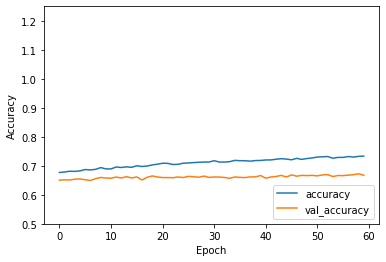

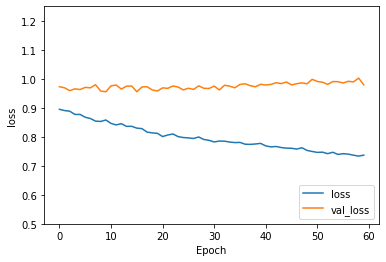

<Figure size 432x288 with 0 Axes>

In [139]:
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.25])
plt.legend(loc='lower right')
plt.figure()


plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.5, 1.25])
plt.legend(loc='lower right')
plt.figure()

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

**What to learn from above graphs:** 

hmmm... This graph is acheived after a number of run of the model to acheive a better accuracy. Validation loss is under 1 now and validation accuracy has shown some improvement too.

<function matplotlib.pyplot.show>

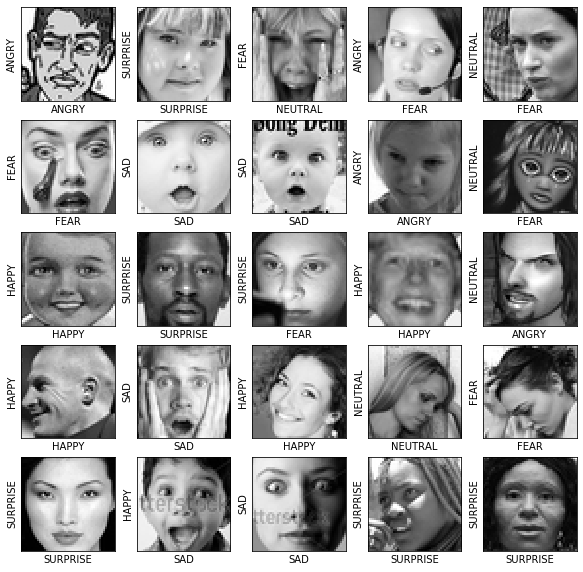

In [160]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_val[i*3]), cmap='gray')
    plt.xlabel(class_names[np.argmax(predictions[i*3])])
    plt.ylabel(class_names[np.argmax(y_val[i*3])])
plt.show

**7** among 25 from the validation set are worng pedicted. This is not good. However the best accuracies acheived on this dataset (according to my knowledge) are not upto the mark. 


#Now preprocessing for Transfer Learning.
Networks like resnet, densenet, vgg etc are trained on rgb image. Fer is a gray scale image they expect a 3dimenional image and usually in a greater size. Increasing size of the image might lead to decreased accuracy but this is the trade-odd we will have to bear with this dataset.

In [197]:
#Making photos 3-dimensional.
print ('before the shape is {}'.format(x_train.shape))
tChannel = np.squeeze(x_train)
tChannel = np.repeat(tChannel[..., np.newaxis],3,-1)
print ('After the shape is {}'.format(tChannel.shape))

'''
#TF's method to decrease overall size. 
sI=tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(x_train),
    name=None
)
'''
#############################################
#valiation set to 3-dimensions
#Making photos 3-dimensional.
print ('before the shape is {}'.format(x_val.shape))
tVal = np.squeeze(x_val)
tVal = np.repeat(tVal[..., np.newaxis],3,-1)
print ('After the shape is {}'.format(tVal.shape))


before the shape is (28709, 48, 48, 1)
After the shape is (28709, 48, 48, 3)
before the shape is (3589, 48, 48, 1)
After the shape is (3589, 48, 48, 3)


In [0]:
img_height, img_width = 120, 120
from skimage.transform import resize
x_train3 = tf.image.resize(tChannel, [img_height, img_width])

#resizing the validation set below
x_val3 = tf.image.resize(tVal, [img_height, img_width])
#print('x_val3 size is: {} : x_train3 is {}'.format(nValBatch.shape, x_train3.shape))

In [199]:
print('x_train3 size is: {} : x_val3 : {}'.format(x_train3.shape, x_val3.shape))

x_train3 size is: (28709, 120, 120, 3) : x_val3 : (3589, 120, 120, 3)


In [0]:
#from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121

In [0]:
base_model =DenseNet121(
    include_top = True,
    weights     = None,
    input_shape = (img_height, img_width, 3))

In [0]:
base_model.load_weights('/content/drive/My Drive/DenseNet-BC-121-32.h5')

In [0]:
for layer in base_model.layers:
  layer.trainable = False

In [221]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 126, 126, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 60, 60, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 60, 60, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [222]:
last_layer = base_model.get_layer('pool4_conv')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [0]:
#x = tf.keras.layers.BatchNormalization()
#x = tf.keras.layers.GlobalAveragePooling2D

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.3)(x)     
x = tf.keras.layers.Dense(256, activation='relu')(x) 
#x = tf.keras.layers.Dropout(0.4)(x)     
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)   
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (7, activation='softmax')(x)           

model = tf.keras.models.Model(base_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   #shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   #vertical_flip = True,
                                   fill_mode = 'nearest')



###############
test_datagen = ImageDataGenerator(rescale = 1./255.,)

In [229]:
# run model
hist = model.fit_generator( train_datagen.flow(x_train3, y_train, batch_size=batch_size), epochs=epochs,
                 shuffle=True,
                 steps_per_epoch=len(x_train3) // batch_size,
                 callbacks=[earlyStopping, reduce_lr_loss],
                 validation_data=test_datagen.flow(x_val3, y_val),
                 verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 448 steps, validate for 113 steps
Epoch 1/60
448/448 [==============================] - 95s 212ms/step - loss: 1.0325 - acc: 0.6111 - val_loss: 1.4874 - val_acc: 0.4882
Epoch 2/60
448/448 [==============================] - 96s 214ms/step - loss: 1.0233 - acc: 0.6179 - val_loss: 1.4938 - val_acc: 0.4884
Epoch 3/60
448/448 [==============================] - 96s 215ms/step - loss: 1.0219 - acc: 0.6165 - val_loss: 1.4672 - val_acc: 0.4901
Epoch 4/60
448/448 [==============================] - 97s 216ms/step - loss: 1.0181 - acc: 0.6197 - val_loss: 1.4795 - val_acc: 0.4843
Epoch 5/60
448/448 [==============================] - 97s 216ms/step - loss: 1.0196 - acc: 0.6156 - val_loss: 1.4664 - val_acc: 0.4901
Epoch 6/60
448/448 [==============================] - 97s 216ms/step - loss: 1.0129 - acc: 0.6233 - val_loss: 1.4987 - val_acc: 0.4870
Epoch 7/60
448/448 [==============================] - 97s 217ms/step - loss: 1.0153 - acc: 0.618


Transfer learning did not help to improve overall scores. I have tried with removing and including top layers, image augmentation and so on. The best i could get was 51 on validation set.

-- If considered to move with transfer learning in near future: 
1.   consider retraining the 1st layer. Again, not recommended but some people find it to be useful.
2. Consider retraining the network and compare the performance)

